In [10]:
'''
read_chains_example.py: an example to read MCMC chains generated by run_mcmc.py.
Y.S.Murakami 2022 @ JHU
'''
'''
# *********************************************#
# OBJECTIVE OF THE FOLLOWING PART OF THE CODE: #
# *********************************************#

This last part of the code, after reproducing the pipeline of MCMC implemented by the SH0ES team,
is aimed at reproducing the plot shown in Figure 14 of the article.
The structure of the corner plot is freely inspired by Anna D'Ambrosio's file in FinalProject folder.
'''
import numpy as np
import matplotlib.pyplot as plt
import h5py

import sys
import getdist
from getdist import plots


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))

###### config ######
CHAIN_PATH = '/home/git/AstroCosmoComputational/Students/Gabriele_Russo/ExamProject/final_v2_baseline.h5' 
#this file ^ is currently being uploaded to Zenodo
#in the meantime it is available here https://www.dropbox.com/s/um0oi1xglstii2y/final_v2_baseline.h5.gz?dl=0

BURNIN = 600
####################

# Data is big. Select indices that you are interested in.
idx = [37,38,39,40,41,42,43,45,46]
idx = np.asarray(idx)

# Load data
samples = h5py.File(CHAIN_PATH,'r')['mcmc']['chain'][:,:,idx]

# The loaded chains are raw (=uncut) and you need to apply burnin.
# For the discussion on burnin-size, see Sec. 5.1 (MCMC Sampling) of the SH0ES paper.
samples_burnin = samples[BURNIN:,:,:]

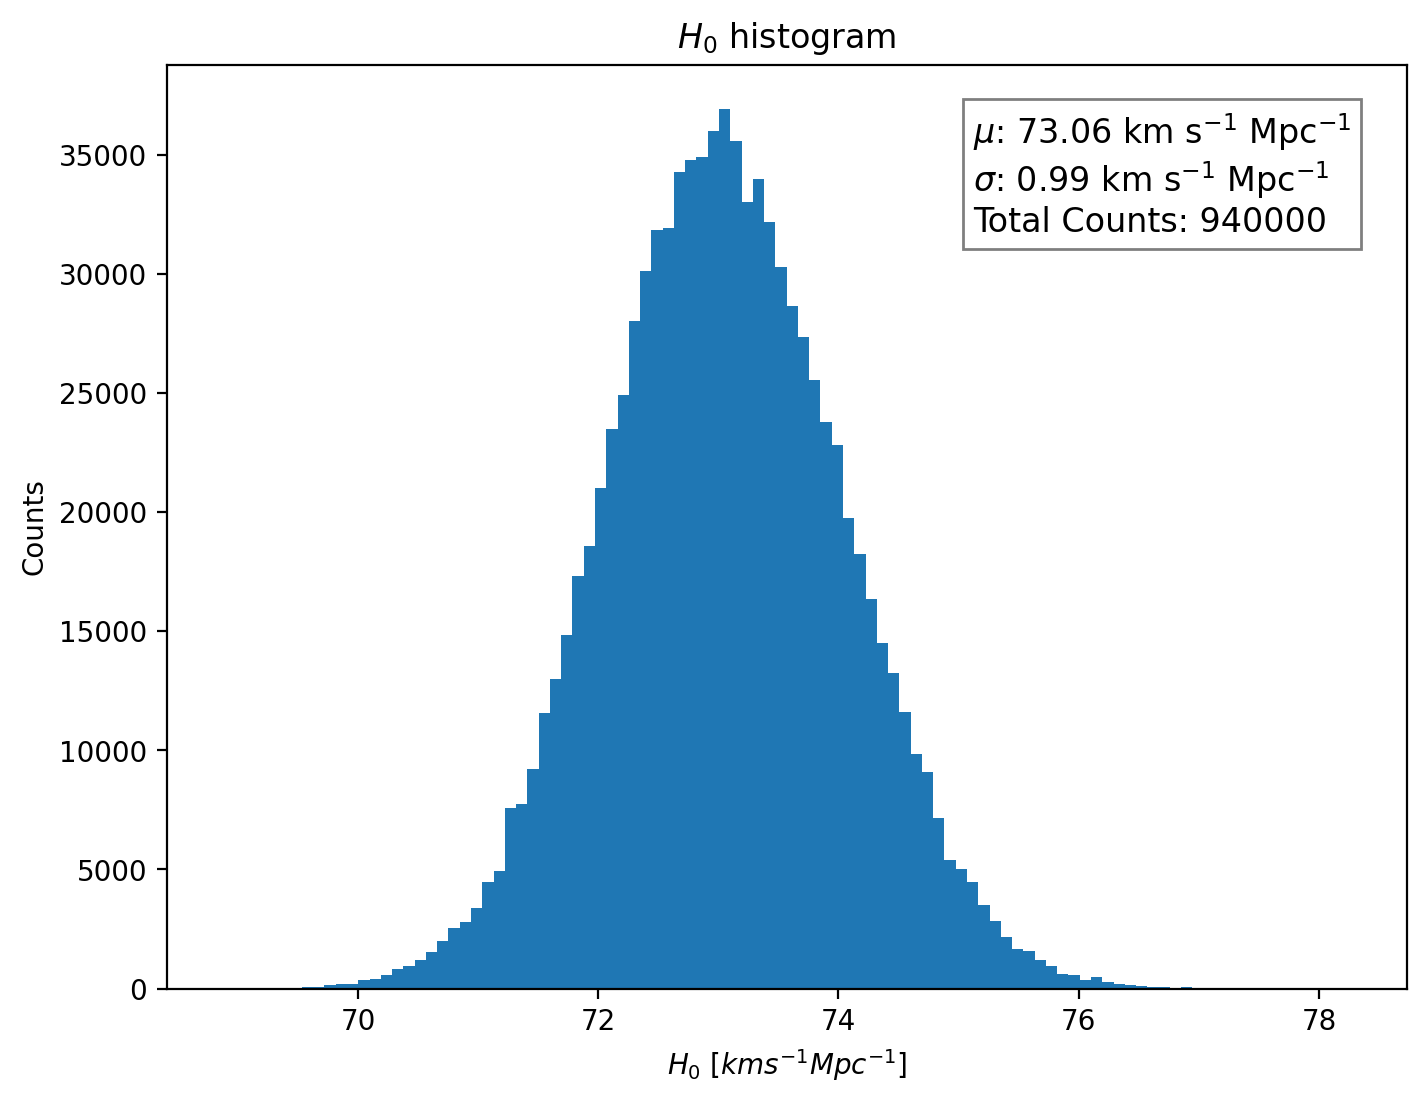

In [11]:
# Once the burnin is applied, one can flatten the chains
# Don't forget to apply formula to obtain the physical quantity.
H0_idx = -1
fivelogH0 = samples_burnin[:,:,H0_idx].flatten()

H0_samples = 10**(fivelogH0/5)

mu_H0 = H0_samples.mean()
std_H0 = H0_samples.std()

# Now it's ready for analyses/plotting!
plt.figure(figsize=(8,6))
counts, bin_edges, _ = plt.hist(H0_samples,bins=100)
total_points = np.sum(counts)

# Text to be plotted
textstr = '\n'.join((
    f'$\mu$: {mu_H0:.2f} km s$^{{-1}}$ Mpc$^{{-1}}$',
    f'$\sigma$: {std_H0:.2f} km s$^{{-1}}$ Mpc$^{{-1}}$',
    f'Total Counts: {int(total_points)}'
))

# Adding text
props = dict(boxstyle='square', facecolor='white', alpha=0.5)
plt.text(0.65, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.title(r'$H_0$ histogram')
plt.xlabel(r'$H_0$ $[km s^{-1} Mpc^{-1}]$')
plt.ylabel('Counts')
plt.show()


Removed no burn in


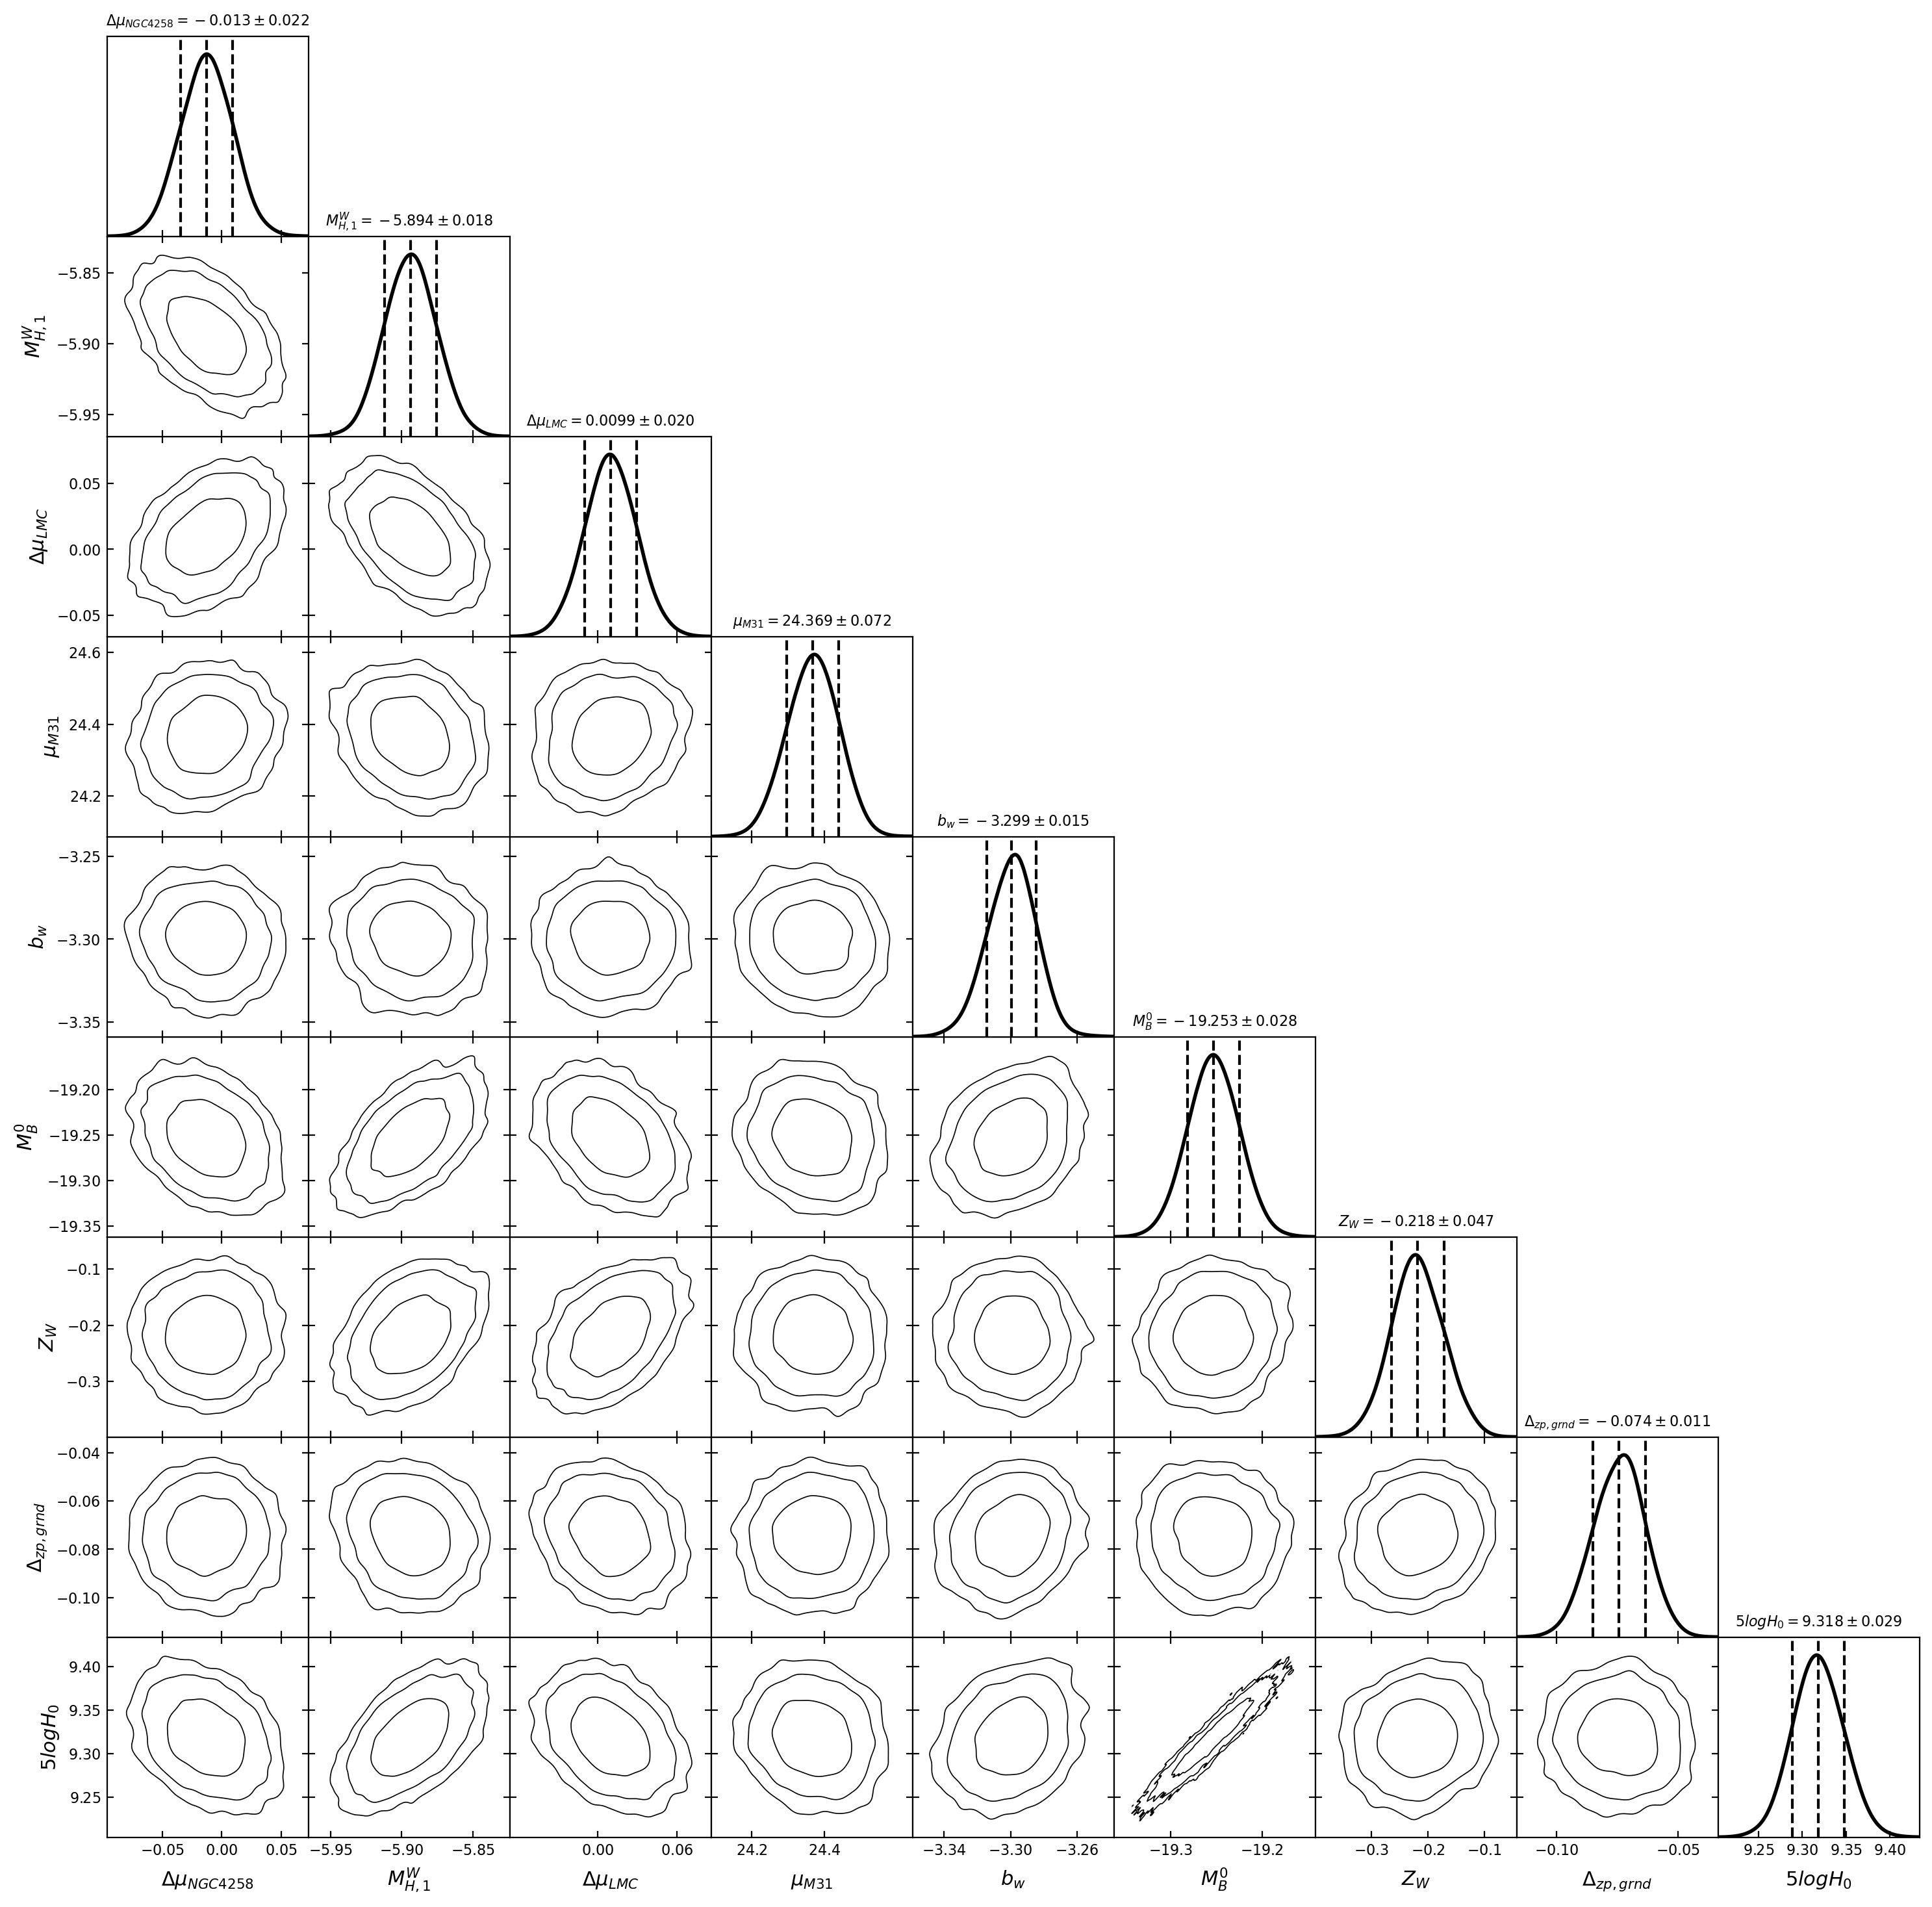

In [12]:
# corner plot
'''
# The loaded chains are raw (=uncut) and you need to apply burnin.
# For the discussion on burnin-size, see Sec. 5.1 (MCMC Sampling) of the SH0ES paper.
samples_burnin = samples[BURNIN:,:,:]

# Once the burnin is applied, one can flatten the chains
# Don't forget to apply formula to obtain the physical quantity.
'''
# Defining all the parameters that will be plotted
H0_idx = -1
fivelogH0 = samples_burnin[:,:,H0_idx].flatten()
zp_idx = 7
deltazp = samples_burnin[:,:,zp_idx].flatten()
Zw_idx = 6
Zw = samples_burnin[:,:,Zw_idx].flatten()
MSN_idx = 5
MSN = samples_burnin[:,:,MSN_idx].flatten()
bw_idx = 4
# Subtract to each entry a constant
bw = samples_burnin[:,:,bw_idx].flatten() - 3.285 
muM31_idx = 3
muM31 = samples_burnin[:,:,muM31_idx].flatten()
muLMC_idx = 2
muLMC = samples_burnin[:,:,muLMC_idx].flatten()
MC_idx = 1
MC = samples_burnin[:,:,MC_idx].flatten()
muNGC4258_idx = 0
muNGC4258 = samples_burnin[:,:,muNGC4258_idx].flatten()

# Defining the mean values of the parameters
mu_fivelogH0 = fivelogH0.mean()
mu_deltazp = deltazp.mean()
mu_Zw = Zw.mean()
mu_MSN = MSN.mean()
mu_bw = bw.mean() 
mu_muM31 = muM31.mean()
mu_muLMC = muLMC.mean()
mu_MC = MC.mean()
mu_muNGC4258 = muNGC4258.mean()


# Plotting the corner plot
names = ["muNGC4258","MC","muLMC","muM31", "bw","MSN", "Zw","deltazp","fivelogH0"]
labels = ["\Delta \mu_{NGC4258}","M_{H,1}^W","\Delta \mu_{LMC}","\mu_{M31}", "b_w","M_B^0", "Z_W","\Delta_{zp, grnd}","5logH_0"]

# Modifying the samples to subtract a constant to the bw parameter
samples_burnin_modified = samples_burnin.copy()
samples_burnin_modified[:, :, 4] -= 3.285

samples_MCMC = getdist.mcsamples.MCSamples(samples=samples_burnin_modified,names = names, labels = labels, settings={
    'smooth_scale_1D': 0.3,
    'smooth_scale_2D': 1.,
    'num_bins': 2000
})

g = plots.getSubplotPlotter()

g.settings.num_plot_contours = 3

g.triangle_plot(samples_MCMC,
                filled=False,
                line_args={'ls':'-','lw':2, 'color':'black'},
                contour_colors=['black'],
                contour_ls=['-'],
                legend_loc='upper right',
                title_limit=1, # first title limit (for 1D plots) is 68% by default
                markers={'\Delta \mu_{NGC4258}':[mu_muNGC4258], 'M_{H,1}^W':[mu_MC], 
                         '\Delta \mu_{LMC}':[mu_muLMC], '\mu_{M31}':[mu_muM31], 'b_w':[bw], 
                         'M_B^0':[mu_MSN], 'Z_W':[mu_Zw], '\Delta_{zp, grnd}':[mu_deltazp], 
                         '5logH_0':[mu_fivelogH0]})

# Adding vertical lines to the 1D plots for mean and 1 sigma region
def mean_and_sigma(samples):
    mean = np.mean(samples)
    sigma = np.std(samples)
    return mean, sigma

for i, param in enumerate(samples_MCMC.getParamNames().names):
    samples = samples_MCMC.samples[:, i]
    mean, sigma = mean_and_sigma(samples)
    ax = g.subplots[i, i]  # Obtaining the 1D plot
    ax.axvline(mean, color='black', linestyle='--', lw=1.5)
    ax.axvline(mean - sigma, color='black', linestyle='--', lw=1.5)
    ax.axvline(mean + sigma, color='black', linestyle='--', lw=1.5)

plt.show()